<a href="https://colab.research.google.com/github/rahiakela/kaggle-competition-projects/blob/master/denoising-dirty-documents/03_denoising_images_with_cnn_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Denoising CNN Autoencoder

In this notebook, we'll try and build an autoencoder CNN with the Keras library. An autoencoder is just a CNN the compresses the input into a smaller representation, and then tries to reconstruct the original input from the compressed representation. The idea is that the network will learn to extract the most important features of the input, and then use those features to reconstruct the input.

![Image Description](https://miro.medium.com/v2/resize:fit:1200/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)


**Outline**

- First, we'll do some data exploration and cleaning
- Second, we'll build our simple autoencoder and check how it performs
- Third, we'll try to see how much better OCR (Optical Character Recognition) performs on the denoised images


**Reference**:

https://www.kaggle.com/code/nico404/denoise-images-w-cnn-autoencoder-keras-tf-ocr

##Setup

In [ ]:
!sudo apt install build-essential libpoppler-cpp-dev pkg-config python3-dev

In [ ]:
%%shell

sudo apt install tesseract-ocr
sudo apt-get install poppler-utils
pip install tesseract
pip install pytesseract

Just restart the colab environment.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import zipfile
from PIL import Image
import pytesseract

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.callbacks import EarlyStopping

In [2]:
pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')

In [ ]:
import cv2
from pdf2image import convert_from_path
from io import BytesIO
from PIL import Image

In [ ]:
from google.colab import files
files.upload() # upload kaggle.json file

In [4]:
%%shell

mkdir -p ~/.kaggle
mv kaggle.json ~/.kaggle/
ls ~/.kaggle
chmod 600 /root/.kaggle/kaggle.json

# download dataset from kaggle> URL: https://www.kaggle.com/competitions/denoising-dirty-documents
kaggle competitions download -c denoising-dirty-documents

unzip -qq denoising-dirty-documents.zip

mkdir denoising-dirty-documents
mv train.zip test.zip train_cleaned.zip denoising-dirty-documents/

rm -rf denoising-dirty-documents.zip

kaggle.json
 92% 33.0M/35.7M [00:00<00:00, 98.2MB/s]
100% 35.7M/35.7M [00:00<00:00, 84.6MB/s]


In [5]:
# unzip files
files = os.listdir("denoising-dirty-documents")
for f in files:
  print(f)
  with zipfile.ZipFile("denoising-dirty-documents/" + f, "r") as zip_ref:
    zip_ref.extractall("denoising-dirty-documents/working")

test.zip
train_cleaned.zip
train.zip


In [6]:
# create directories for the project
os.mkdir("denoising-dirty-documents/working/train_cleaned_resized")
os.mkdir("denoising-dirty-documents/working/train_resized")
os.mkdir("denoising-dirty-documents/working/test_resized")

##Image pre-processing

In [7]:
# Store images path into lists
train_images, test_images, cleaned_images = list(), list(), list()

base_path = "denoising-dirty-documents/working"
train_images = [os.path.join(f"{base_path}/train", image) for image in os.listdir(f'{base_path}/train')]
test_images = [os.path.join(f"{base_path}/test", image) for image in os.listdir(f'{base_path}/test')]
cleaned_images = [os.path.join(f"{base_path}/train_cleaned", image) for image in os.listdir(f'{base_path}/train_cleaned')]

In [8]:
train_images[0], test_images[0], cleaned_images[0]

('denoising-dirty-documents/working/train/188.png',
 'denoising-dirty-documents/working/test/127.png',
 'denoising-dirty-documents/working/train_cleaned/188.png')

In [9]:
# Process images and check all different sizes in the dataset
def get_different_sizes(images):
    different_sizes = set()
    for image in images:
        img = plt.imread(image)
        different_sizes.add(img.shape)
    return different_sizes

train_different_sizes = get_different_sizes(train_images)
cleaned_different_sizes = get_different_sizes(cleaned_images)
test_different_sizes = get_different_sizes(test_images)

print(train_different_sizes)
print(cleaned_different_sizes)
print(test_different_sizes)

{(420, 540), (258, 540)}
{(420, 540), (258, 540)}
{(420, 540), (258, 540)}


In [10]:
small_size = (258, 540)
big_size = (420, 540)

def count_images(images, small_size, big_size):
    count_small, count_big = 0, 0

    for image in images:
      img = plt.imread(image)
      if img.shape == small_size:
        count_small += 1
      elif img.shape == big_size:
        count_big += 1
    return count_small, count_big

x_train_counts = count_images(train_images, small_size, big_size)
y_train_counts = count_images(cleaned_images, small_size, big_size)
x_test_counts = count_images(test_images, small_size, big_size)

column_names = ["small_img", "big_img"]
row_labels = ["x_train", "y_train", "x_test"]

counts_matrix = [x_train_counts, y_train_counts, x_test_counts]

img_df = pd.DataFrame(counts_matrix, columns=column_names, index=row_labels)
img_df

,small_img,big_img
x_train,48,96
y_train,48,96
x_test,24,48


Ok, so we got twice as much big images as we got small ones, and we get the same distribution in all our sets.

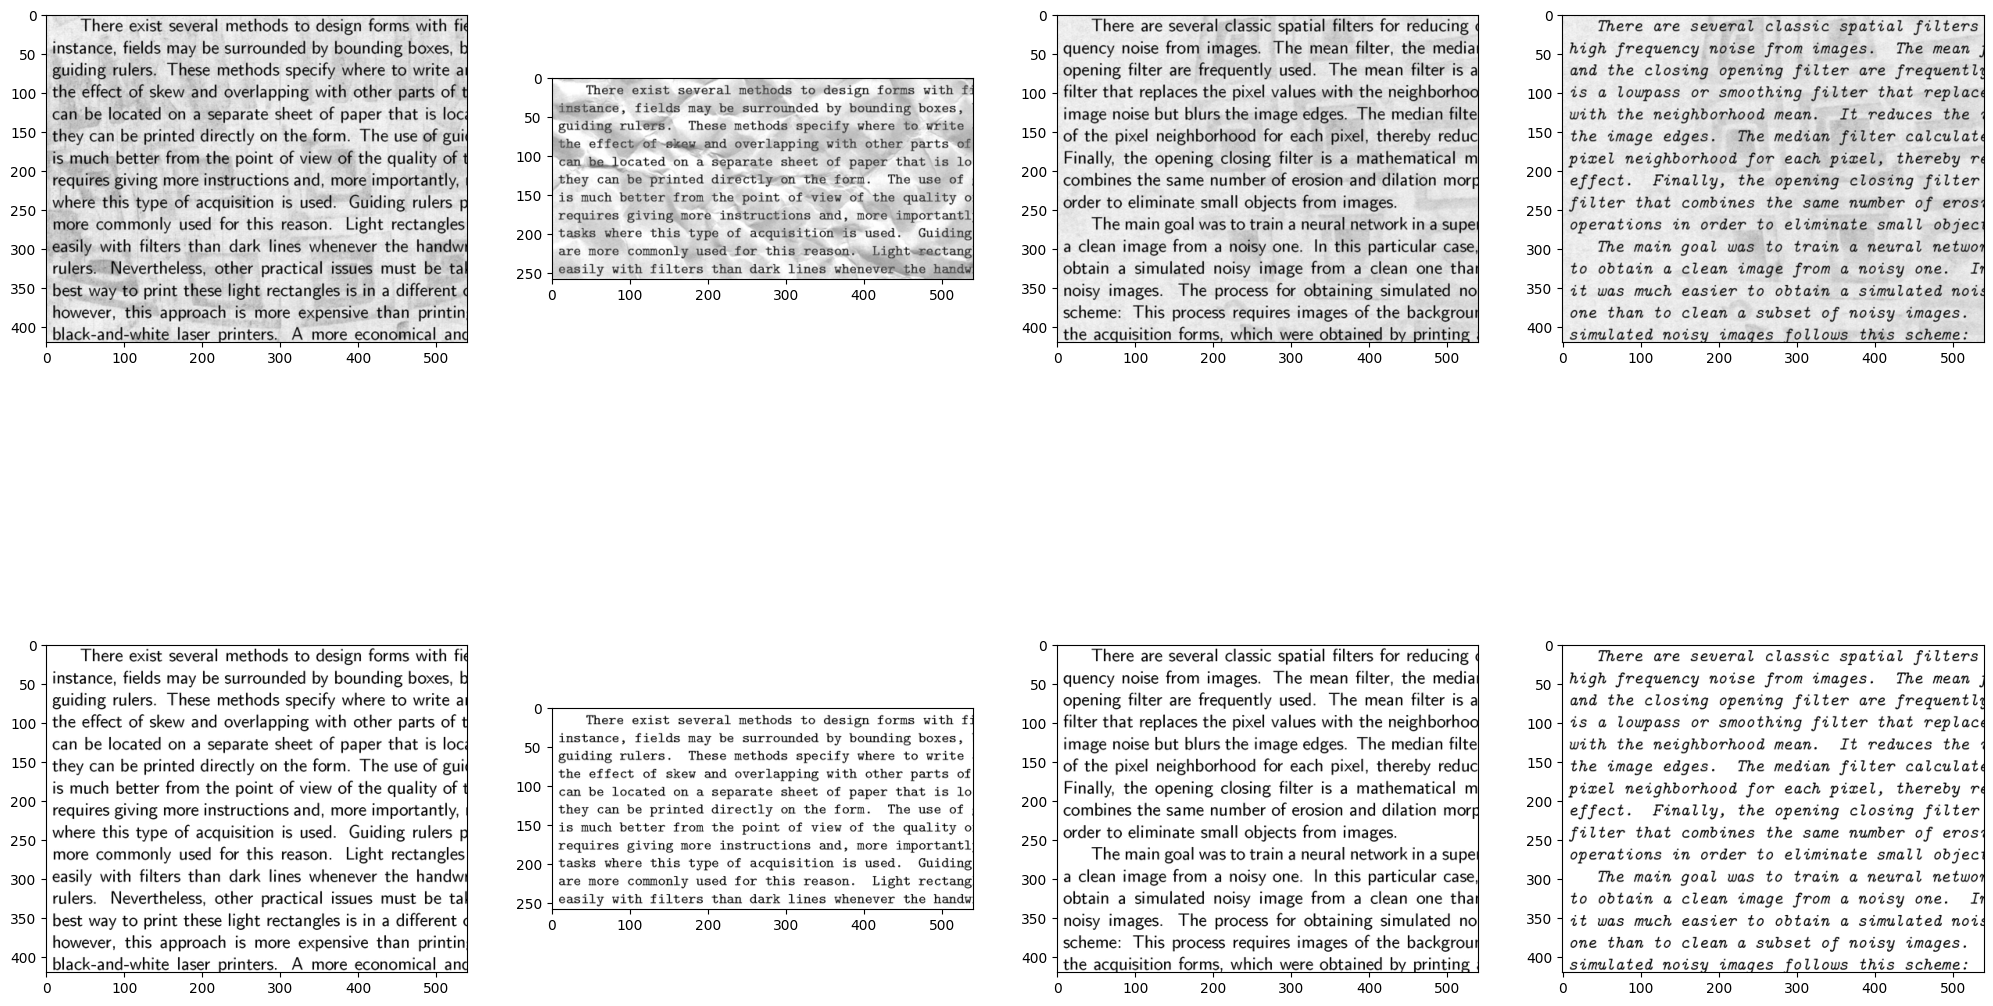

In [11]:
fix, ax = plt.subplots(2, 4, figsize=(25, 15))

for i in range(4):
  img = plt.imread(train_images[i])
  ax[0, i].imshow(img, cmap='gray')

for i in range(4):
  img = plt.imread(cleaned_images[i])
  ax[1, i].imshow(img, cmap='gray')

plt.show()

**At First glance what do we see and what could we be doing?**

- there aren't that many images
- we should resize all our images to the same size -> If we cut the big images into 2 small ones, we'll increase our dataset size --> me likey data augmentation
- let's apply grayscale to all our images since it's only text
- We should make sure that for each image we have a corresponding denoised image

-> then we can start thinking about how to denoise our images and how to train our model

Do we have the same number of images in each set?

In [12]:
train_images.sort() == cleaned_images.sort()

True

**RESIZING**

When we get a big image, we'll want to make it into 2. Since 420 can't be divided by an int to get 258, let's be smart and keep the top 258 pixels and the bottom 258 pixels so we get 2 images of `258x540`.

Let's apply that to `X_train`, `y_train` and `X_test`. Also let's check again that we have a perfect `X / y` match.

In [13]:
def split_and_save_images(images, output_folder):
  for image in images:
    img = plt.imread(image)
    if img.shape == (420, 540):
      # Split the image into two images of size 258x540
      img1 = img[0:258, :]
      img2 = img[(420-258):, :]

      filename = os.path.basename(image).split(".")[0]
      filename1 = filename + "_1.png"
      filename2 = filename + "_2.png"

      # Save the two images into the output folder
      plt.imsave(os.path.join(output_folder, filename1), img1, cmap="gray")
      plt.imsave(os.path.join(output_folder, filename2), img2, cmap="gray")
    else:
      # Save the small image into the output folder without cropping
      filename = os.path.basename(image)
      plt.imsave(os.path.join(output_folder, filename), img, cmap="gray")

In [14]:
split_and_save_images(train_images, f"{base_path}/train_resized")
split_and_save_images(cleaned_images, f"{base_path}/train_cleaned_resized")
split_and_save_images(test_images, f"{base_path}/test_resized")

In [15]:
# Building new lists of images from the new folders
train_images_resized = [os.path.join(f"{base_path}/train_resized", image) for image in os.listdir(f"{base_path}/train_resized")]
test_images_resized = [os.path.join(f"{base_path}/test_resized", image) for image in os.listdir(f"{base_path}/test_resized")]
cleaned_images_resized = [os.path.join(f"{base_path}/train_cleaned_resized", image) for image in os.listdir(f"{base_path}/train_cleaned_resized")]

In [16]:
train_images_resized.sort() == cleaned_images_resized.sort()

True

**Reshaping**

(258, 540, 4)

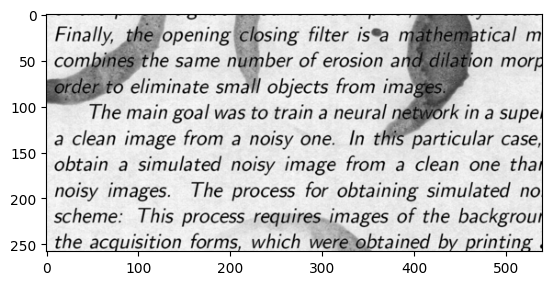

In [17]:
image_path = train_images_resized[100]
img = plt.imread(image_path)
plt.imshow(img, cmap="gray")
img.shape

It looks like there is an alpha channel sometimes in the images, let's get rid of it and build our np array.

In [18]:
def process_images(image_paths):
  image_array = np.empty((len(image_paths), 258, 540, 1), dtype=np.float32)

  for i, image_path in enumerate(image_paths):
    img = plt.imread(image_path)
    if img.shape[-1] == 4:    # Check if the image has an alpha channel
      img = img[..., :3]      # Discard the alpha channel by selecting only the first three channels

    if len(img.shape) == 2:   # Check if the image is already grayscale
      gray_img = img[..., np.newaxis]  # Add a new axis to make it (height, width, 1)
    else:
      gray_img = np.mean(img, axis=2, keepdims=True)  # Convert the image to grayscale

    plt.imshow(gray_img[:, :, 0], cmap="gray")
    # Store the image in the array
    image_array[i] = gray_img
  return image_array

(240, 258, 540, 1)
(120, 258, 540, 1)
(240, 258, 540, 1)


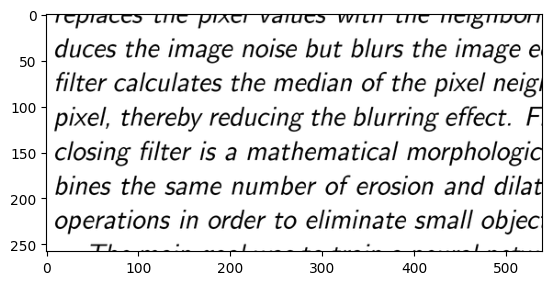

In [19]:
# Process train_images
train_array = process_images(train_images_resized)
print(train_array.shape)

# Process test_images
test_array = process_images(test_images_resized)
print(test_array.shape)

# Process cleaned_images
clean_array = process_images(cleaned_images_resized)
print(clean_array.shape)

Let's make sure that all our images have a normalized shape.

In [20]:
x_train = train_array
x_test = test_array
y_train = clean_array

x_train.shape, x_test.shape, y_train.shape

((240, 258, 540, 1), (120, 258, 540, 1), (240, 258, 540, 1))

##CNN Autoencoders

- Since we're processing images, a CNN network seems like a good idea
- For denoising images, an autoencoder seems like the best option.

**Autoencoder network**:

- loss functin is MSE since we're trying to minimize the difference between the input and the output
- Let's use the RMSE as a metric since the challenge is evaluated on it
- we'll use adam optimizer since it's the best one overall
- we could go deeper with compression for the middle layer but we'll keep it simple for now

In [21]:
def build_model():
  conv_autoencoder = Sequential()

  # Encoder
  conv_autoencoder.add(Conv2D(filters=16, kernel_size=(3,3), input_shape=(258,540,1), activation='relu', padding='same'))
  conv_autoencoder.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
  conv_autoencoder.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
  conv_autoencoder.add(MaxPooling2D((2, 2), padding='same'))

  # Decoder
  conv_autoencoder.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'))
  conv_autoencoder.add(Conv2DTranspose(16, kernel_size=(3, 3), activation='relu', padding='same'))

  # Output
  conv_autoencoder.add(Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same'))

  conv_autoencoder.compile(loss="mean_squared_error", optimizer="adam", metrics=tf.metrics.RootMeanSquaredError())
  return conv_autoencoder

In [22]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 258, 540, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 258, 540, 32)      4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 258, 540, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 129, 270, 64)      0         
 D)                                                              
                                                                 
 conv2d_transpose (Conv2DTr  (None, 258, 540, 32)      18464     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 258, 540, 16)      4

We have a very reasonnable param count, let's train it!

- small batch size since we don't have that many images and we don't want to overfit
- add a patience and early stopping to stop training when we're not improving anymore
- let's go with 70/30 validation split

In [ ]:
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

model = build_model()

history= model.fit(x_train, y_train, validation_split = 0.3, epochs=30, batch_size=16, callbacks= [early_stop], verbose=1)

##Loss and Accuracy

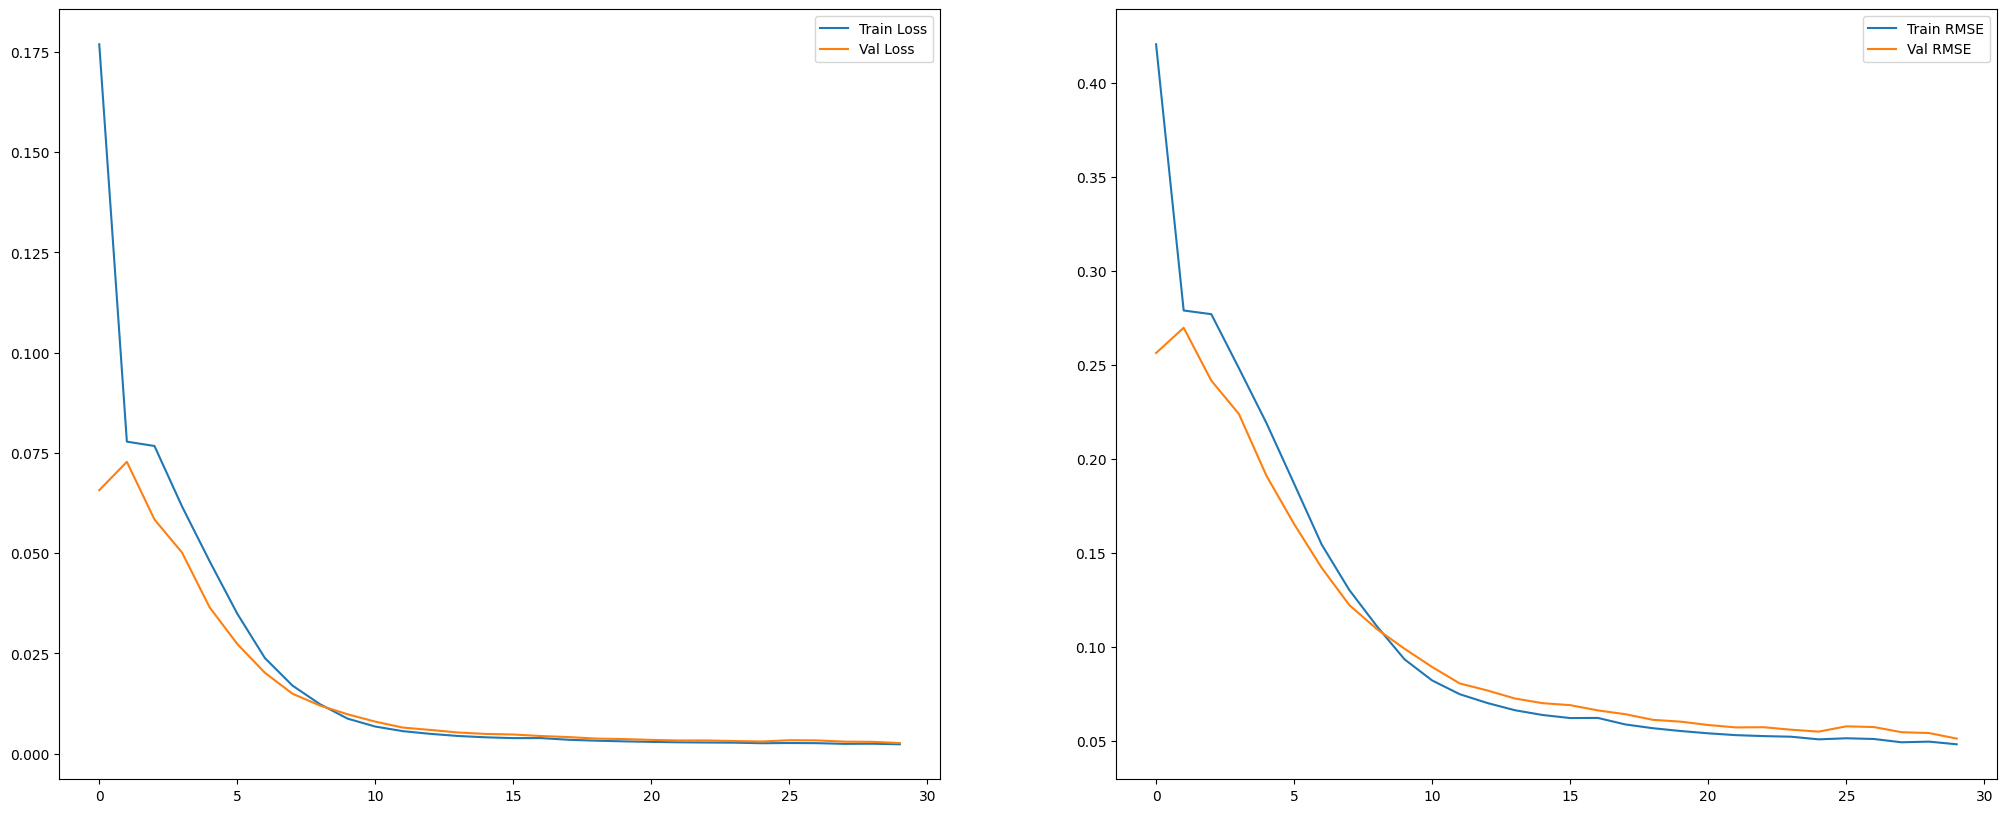

In [25]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_rmse = history.history['root_mean_squared_error']
epoch_val_rmse = history.history['val_root_mean_squared_error']

fig, ax = plt.subplots(1, 2, figsize=(25, 10))
ax[0].plot(epoch_loss, label='Train Loss')
ax[0].plot(epoch_val_loss, label='Val Loss')
ax[0].legend()

ax[1].plot(epoch_rmse, label='Train RMSE')
ax[1].plot(epoch_val_rmse, label='Val RMSE')
ax[1].legend()

plt.show()

We've converged pretty quickly, and we can see very similar curves since mse and rmse are directly correlated.
We have not reached our Early Stopping Criteria, but it seems like we're not improving much anymore so let's stop here.


##Prediction

In [26]:
y_pred = model.predict(x_test)

4/4 [==============================] - 7s 988ms/step


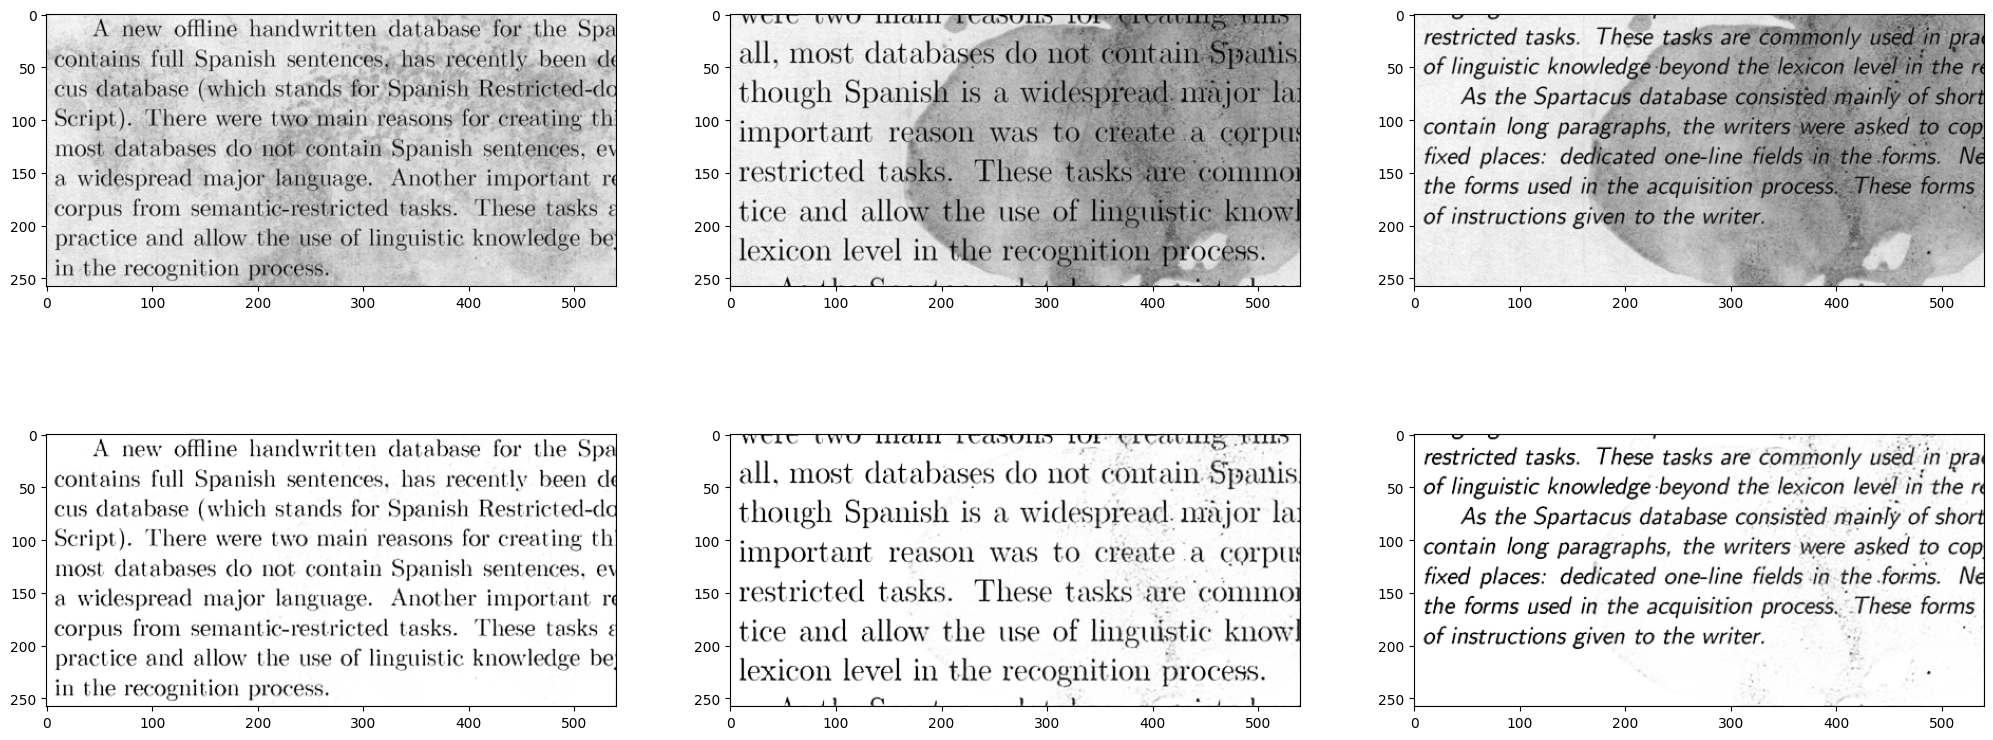

In [27]:
plt.figure(figsize=(25,10))
for i in range(3):
  plt.subplot(2, 3, i+1)
  plt.imshow(x_test[i], cmap='gray')

  plt.subplot(2, 3, 3+i+1)
  plt.imshow(y_pred[i], cmap='gray')

plt.show()

##Denoising image

Let's perform ocr on the images and compare the results.

In [ ]:
def img_display(im_data):
    dpi = 80
    #im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

In [ ]:
pdf_file = 'document-page40.pdf'
pages = convert_from_path(pdf_file)
for page in pages:
  page.save("doc.jpg", "JPEG")

In [ ]:
image = cv2.imread("doc.png")
# Binarization
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
gray_image.shape

(439, 1062)

In [ ]:
img_display(gray_image)

In [ ]:
resized_img = cv2.resize(gray_image, (420, 540), interpolation=cv2.INTER_AREA)

In [ ]:
img_display(resized_img)

In [ ]:
resized_img = resized_img[..., np.newaxis]
resized_img.shape

(540, 420, 1)

In [ ]:
y_pred = conv_autoencoder.predict(resized_img)

In [ ]:
y_pred[0]

array([[[1.],
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        [1.]]], dtype=float32)

In [ ]:
cv2.imwrite("out.png", y_pred)

False

In [ ]:
#image = cv2.imread("doc.jpg")

# img_display(y_pred)
plt.imshow(y_pred[0][:,:,0], cmap='gray')